В игре происходят бои. На бой игрок выставляет 4-х бойцов, каждый боец вооружен некоторым оружием. После того, как завершается бой, происходит запись информации об этом бое. 

Записываются:
* Уникальный id боя.

* Для каждого бойца тип оружия (4 столбца).

* Длительность боя (в секундах).

В некоторый момент были изменены настройки баланса оружия. Нужно понять, повлияло ли изменение настроек на длительность боя. Считаем, что длительность боя зависит только от комбинации 4-х оружий, сам порядок не важен. Например, 'меч, меч, лук, булава' и 'лук, меч, булава, меч' - одна и та же комбинация. Последний столбец в датасете - отметка о том, когда был совершен бой, до изменений в балансе или после.


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [72]:
df = pd.read_csv(r'C:\Современные методы анализа данных\analyst(my_games)_test\data_test.csv', encoding='windows-1251')

In [73]:
df.head()

,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
0,103921,топор,лук,булава,лук,17.35,before
1,117214,посох,посох,лук,лук,21.84,before
2,115502,меч,посох,булава,топор,16.00,before
3,110102,булава,лук,лук,булава,17.22,before
4,104989,меч,посох,булава,посох,19.20,before


In [74]:
df.shape

(20000, 7)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   battle_id     20000 non-null  int64  
 1   unit_1        20000 non-null  object 
 2   unit_2        20000 non-null  object 
 3   unit_3        20000 non-null  object 
 4   unit_4        20000 non-null  object 
 5   len           20000 non-null  float64
 6   balance_mark  20000 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [76]:
# в каждой из 4 колонок unit_i - 5 уникальных значений
df[['unit_1', 'unit_2', 'unit_3', 'unit_4']].nunique()

unit_1    5
unit_2    5
unit_3    5
unit_4    5
dtype: int64

In [77]:
# уникальные значения
df.unit_1.unique(), df.unit_2.unique(), df.unit_3.unique(), df.unit_4.unique()

(array(['топор', 'посох', 'меч', 'булава', 'лук'], dtype=object),
 array(['лук', 'посох', 'меч', 'булава', 'топор'], dtype=object),
 array(['булава', 'лук', 'меч', 'топор', 'посох'], dtype=object),
 array(['лук', 'топор', 'булава', 'посох', 'меч'], dtype=object))

In [78]:
# Проверка, что в наборе данных все названия видов оружия имеют одинаковое правописание
# (нет замены русских букв похожими английскими и т.д.)
l = [df.unit_1, df.unit_2, df.unit_3, df.unit_4]
for i in l:
    print(len(df[i == 'булава']) +
          len(df[i == 'посох']) +
          len(df[i == 'меч']) +
          len(df[i == 'лук']) +
          len(df[i == 'топор']))

20000
20000
20000
20000


In [79]:
# длина выборок (до, после)
len(df.len[df.balance_mark == 'before']), len(df.len[df.balance_mark == 'after'])

(10000, 10000)

По условию кейса нужно оставить только одну комбинацию оружия. Одна комбинация оружия может повторяться неограниченное количество раз в каждой выборке (before и after).

In [80]:
def func(data):
    dataset = df[df.balance_mark == str(data)]
    dataset = dataset.drop(columns=['battle_id'])
    
    dataset['index'] = range(10000)
    dataset.set_index(['index'], inplace=True)
    
    dataset_list = []
    for i in range(10000):
        b = [dataset.unit_1[i], dataset.unit_2[i], dataset.unit_3[i], dataset.unit_4[i]] # список unit_i каждого наблюдения
        dataset_list.append([b, dataset.len[i]]) 
        
    dataset_list_final = []
    combinations_dataset = []

    """
    Так как нужно оставить только одну комбинацию оружия и все наблюдения с данной комбинацией, создадим 2 пустых списка.
    В список (combinations_dataset) будем добавлять отсортированные комбинации unit. Список будет содержать только уникальные 
    наборы оружия. Сортировка значений в списке позволит избавиться от дубликатов. Списки, в которых разный порядок элементов, 
    при сортировке принимают одинаковый вид. В список (dataset_list_final) добавляем одну комбинацию оружия. Это самая
    первая комбинация, которую мы считываем в цикле (по условию нам не говорится о том, какую комбинацию оставить, главное, 
    чтобы она была уникальная). В итоге, при проверке условия мы смотрим на наличие уникальной комбинации в 
    combinations_dataset. Если такой комбинации нет, добавляем ее, а в список dataset_list_final добавляем одну (первую)
    комбинацию.
    """
    
    for i in range(10000):
        if sorted(dataset_list[i][0]) not in combinations_dataset:
            combinations_dataset.append(sorted(dataset_list[i][0]))
            dataset_list_final.append(dataset_list[i][0])
    
    """
    Если комбинация оружия содержится в списке dataset_list_final, добавляем ее в датасет final_df вместе с длительностью боя и 
    отметкой совершения боя. В итоге в final_df будет находиться только одна комбинация каждого набора оружия и всевозможные
    бои с этой комбинацией.
    """
    
    final_df = pd.DataFrame(columns=['set', 'time', 'type'])
    for i in range(10000):
        if dataset_list[i][0] in dataset_list_final:
            final_df = final_df.append(pd.Series([dataset_list[i][0] 
                                                  ,dataset_list[i][1] 
                                                  ,data]
                                                  ,index=['set','time','type'])
                                                  ,ignore_index=True)
    
    
    
    return final_df.time 

In [81]:
len(func('before')), len(func('after'))

(1190, 1189)

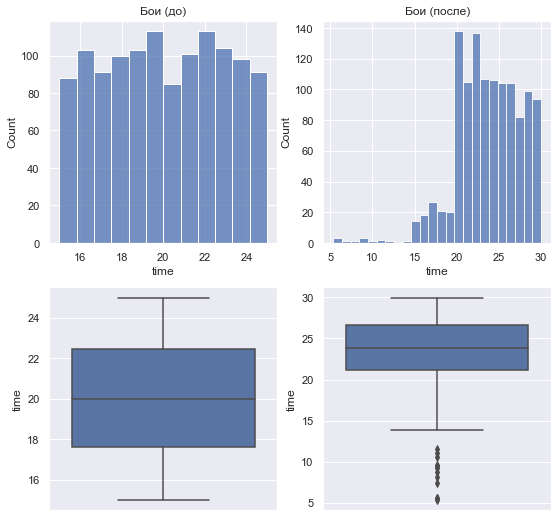

In [82]:
fig, ax = plt.subplots(nrows=2, ncols=2)

sns.histplot(func('before'), ax=ax[0][0])
ax[0][0].set_title('Бои (до)')
sns.histplot(func('after'), ax=ax[0][1])
ax[0][1].set_title('Бои (после)')

sns.boxplot(y = func('before'), ax=ax[1][0])
sns.boxplot(y = func('after'), ax=ax[1][1])

sns.set(rc={'figure.figsize':(9, 9)})

In [83]:
print(func('before').mean(), func('after').mean())
print(func('before').median(), func('after').median())
print(func('before').std(), func('after').std())

20.03566386554622 23.737594617325485
19.975 23.8
2.8254531890930843 3.8180206588429395


Меры центральной тенденции (мода, медиана) и мера изменчивости (стандартное отклонение) позволяют предположить, что выборки распределены нормальным образом (стандартное отклонение меньше среднего и меньше медианы). Но в выборке "до изменений" медианное значение меньше среднего. В выборке "после изменений" медианое значение превосходит среднее на ≈ 0.07, что не очень много. Данные наблюдения позволяют предположить, что в данных могут быть выбросы. Такое предположение подтверждает и визуаьный аналз графиков. На графике boxplot выборки "после изменений" видны заметные выбросы на промежутке от 5 до ≈ 12. Проверим свои предположения статистическим тестом Шапиро — Уилка. 

In [84]:
stats.shapiro(func('before')), stats.shapiro(func('after'))

(ShapiroResult(statistic=0.957329273223877, pvalue=3.768649346452314e-18),
 ShapiroResult(statistic=0.9565922021865845, pvalue=2.6450212644306944e-18))

P-value 2 выборок получился меньше уровня значимости в 0.05. Таким образом нулевая гипотеза о нормальности распределения отклоняется и можно сделать вывод, что данные распределены не нормальным образом. Для сравнения 2 выборок будем использовать непараметрический статистический критерий (Манна — Уитни), так как параметрический тест (например, Стьюдент) может плохо работать из-за ненормальности распределения данных.

H(0): Между значениями выборок before и after нет значимых различий;

H(1): Между значениями выборок before и after есть значимые различия;

In [85]:
print(stats.mannwhitneyu(func('before'), func('after')))

MannwhitneyuResult(statistic=305583.0, pvalue=3.5598171667861057e-127)


Отклоняем нулевую гипотезу. 

Вывод: Изменение в настройках баланса оружия значимо повлияло на длительность боя. Средняя продолжительность боя увеличилась. Но вместе с этим, стало меньше боев с продолжительностью боя меньше 20 секунд. Можно предположить, что оружие стало наносить меньше урона противнику => длительность боя возросла, а коротких боев стало меньше.

In [86]:
len(func('before')[func('before') <= 20]), len(func('after')[func('after') <= 20])

(598, 132)